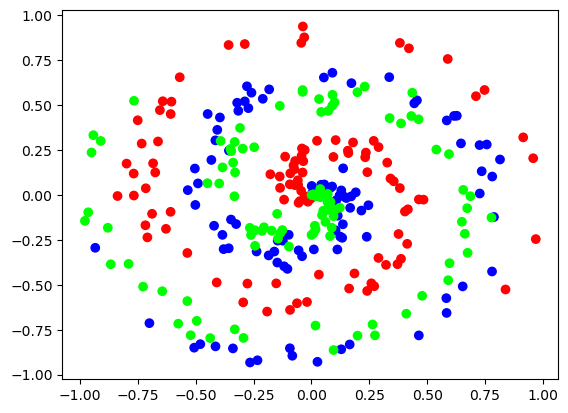

In [184]:
## Coding when learning from Vizuara AI labs
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

X,y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

In [105]:
### Creating Neural network

## Dense Layer
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01*np.random.randn(n_inputs, n_neurons)#0.01 to make it small
        self.biases = np.zeros((1,n_neurons))
        # self.biases = np.random.randn(1,n_neurons)
        
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights) + self.biases
        
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims=1)
        self.dinputs = np.dot(dvalues, self.weights.T)
        
## Activation ReLU
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
        
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

## Activation Softmax
class Activation_Softmax:
    def forward(self, inputs):
        self.inputs = inputs
        exp_val = np.exp(inputs - np.max(inputs, axis = 1, keepdims=1))
        self.output = exp_val/np.sum(exp_val, axis = 1, keepdims = 1)
        
        
# Loss class
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output,y)
        data_loss = np.mean(sample_losses)
        return data_loss

    
## Categorical cross entropy loss
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        n_samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(n_samples), y_true]
        elif len(y_true.shape) == 2:# one-hot encoded 
            correct_confidences = np.sum(y_pred_clipped*y_true, axis = 1)
        
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self, dvalues, y_true):
        n_samples = len(dvalues)
        n_labels = len(dvalues[0])
        
        if len(y_true.shape) == 1:# convert to one-hot vector
            y_true = np.eye(n_labels)[y_true]
            
        self.dinputs = -y_true/dvalues
        self.dinputs = self.dinputs/ n_samples
        
## Combined softmax and categorical cross entropy for last layer
class Activation_Softmax_Loss_CategoricalCrossentropy:
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, dvalues, y_true):
        n_samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis = 1)
            
        self.dinputs = dvalues.copy()
        self.dinputs[range(n_samples), y_true] -= 1# The formula is y_pred - y_true
        # Since all y_true value corresponding to the mentioned index is = 1 we are subtracting by the same
        self.dinputs = self.dinputs/n_samples      
        
        
class SGD_optimizer:
    def __init__(self, learning_rate = 0.5):
        self.learning_rate = learning_rate
        
    def update_params(self,layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases      

In [107]:
# Creating the model

dense1 = Layer_Dense(2,3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Passing the input dataset
dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y)

print("Loss:", loss)
predictions = np.argmax(loss_activation.output, axis = 1)
if len(y.shape) == 2:
    y = np.argmax(predictions == y)
    
accuracy = np.mean(predictions == y)

print("accuracy:", accuracy)

# Calculating the backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)


Loss: 1.0986155
accuracy: 0.3233333333333333
[[ 5.9109250e-05 -6.3369625e-05 -1.0893277e-04]
 [ 6.2572908e-05 -2.6668402e-04  2.6513287e-04]]
[[1.7450169e-05 1.3399607e-04 1.8692267e-04]]
[[ 8.76887352e-05  1.23629388e-05 -1.00051686e-04]
 [-1.22675410e-04  6.44475731e-05  5.82278408e-05]
 [-3.16880833e-05 -4.64897195e-04  4.96585330e-04]]
[[ 1.3677403e-05 -1.0049203e-05 -3.6794227e-06]]


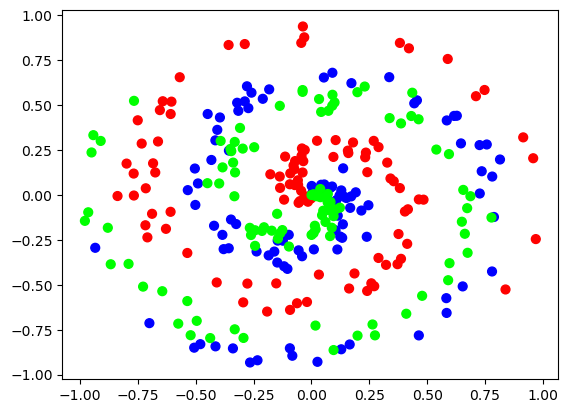

iter  0 : 1.0985943  acc: 0.36
iter  1000 : 1.071239  acc: 0.4
iter  2000 : 1.0280032  acc: 0.48
iter  3000 : 1.0509079  acc: 0.4066666666666667
iter  4000 : 0.9975983  acc: 0.4633333333333333
iter  5000 : 0.93853706  acc: 0.5066666666666667
iter  6000 : 0.9286917  acc: 0.51
iter  7000 : 0.9125562  acc: 0.58
iter  8000 : 0.92687917  acc: 0.5633333333333334
iter  9000 : 0.92166036  acc: 0.55
iter  10000 : 0.9162369  acc: 0.57
0.8898258


In [120]:
# Applying for a Spiral Dataset
### Randomly adjusting weights and biases starting from an initial value
# Create dataset
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()
X,y = spiral_data(samples = 100, classes = 3)
plt.scatter(X[:,0], X[:,1], c = y, s = 40, cmap = 'brg')
plt.show()

# Creating model
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#Declaring optimizer
optimizer = SGD_optimizer()

# Passing the input dataset
dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y)

# Storing variables
min_loss = 99999
best_layer1_weights = dense1.weights.copy()
best_layer1_biases = dense1.biases.copy()
best_layer2_weights = dense2.weights.copy()
best_layer2_biases = dense2.biases.copy()

# Calculating the backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

# print(dense1.biases)
# print(dense1.dbiases)
# print(loss)

# learning_rate = 0.01
for i in range(10001):
    # Forward pass to update the outputs
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)

    accuracy = np.mean(predictions == y)

    
#     print(loss)
    
    if loss<min_loss:
#         print('The New minimum loss is given in iteration: ', i, ' with a minimum loss:', loss, ' and accuracy:', accuracy)
        best_layer1_weights = dense1.weights.copy()
        best_layer1_biases = dense1.biases.copy()
        best_layer2_weights = dense2.weights.copy()
        best_layer2_biases = dense2.biases.copy()
        min_loss = loss
        
    if not i%1000:
        print('iter ', i, ':', loss, ' acc:',accuracy)
    
    # Calculating the backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    #     learning_rate = 0.001*np.random.randn(1)
    # Generating new weights using gradients
    # dense1.weights -= learning_rate*dense1.dweights
    # dense1.biases -= learning_rate*dense1.dbiases
    # dense2.weights -= learning_rate*dense2.dweights
    # dense2.biases -= learning_rate*dense2.dbiases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    
    
#     print(dense1.biases)
#     print(dense1.dbiases)


# print(dense1.biases)
# print(dense1.dbiases)
print(min_loss)
    
  

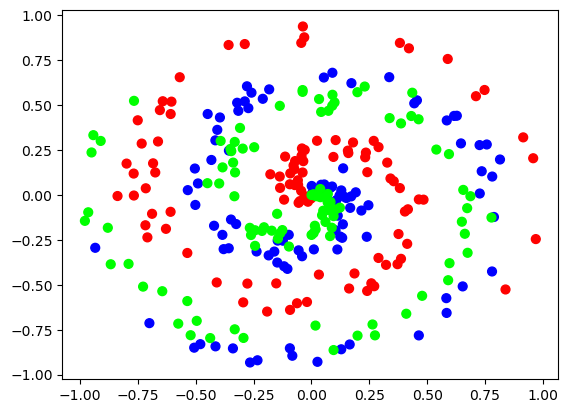

iter  0 : 1.099  acc:0.360 lr: 1.0000
iter  1000 : 1.062  acc:0.400 lr: 0.5003
iter  2000 : 1.037  acc:0.403 lr: 0.3334
iter  3000 : 0.985  acc:0.543 lr: 0.2501
iter  4000 : 0.971  acc:0.520 lr: 0.2000
iter  5000 : 0.973  acc:0.510 lr: 0.1667
iter  6000 : 0.940  acc:0.490 lr: 0.1429
iter  7000 : 0.905  acc:0.593 lr: 0.1250
iter  8000 : 0.874  acc:0.617 lr: 0.1111
iter  9000 : 0.872  acc:0.570 lr: 0.1000
iter  10000 : 0.874  acc:0.647 lr: 0.0909
0.8343324


In [134]:

### Updating the optimizer with the decay rate
class SGD_optimizer_decay:
    def __init__(self, learning_rate = 1, decay = 0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate/ (1 + self.decay*self.iteration)
        
    def update_params(self,layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases  

    def post_update_params(self):
        self.iteration += 1
        

# Applying for a Spiral Dataset
### Randomly adjusting weights and biases starting from an initial value
# Create dataset
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()
X,y = spiral_data(samples = 100, classes = 3)
plt.scatter(X[:,0], X[:,1], c = y, s = 40, cmap = 'brg')
plt.show()

# Creating model
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#Declaring optimizer
optimizer = SGD_optimizer_decay(decay = 0.001)

# Passing the input dataset
dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y)

# Storing variables
min_loss = 99999
best_layer1_weights = dense1.weights.copy()
best_layer1_biases = dense1.biases.copy()
best_layer2_weights = dense2.weights.copy()
best_layer2_biases = dense2.biases.copy()

# Calculating the backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

learning_rate = 1
decay_rate = 0.1
for i in range(10001):
    # Forward pass to update the outputs
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)

    accuracy = np.mean(predictions == y)

    if loss<min_loss:
#         print('The New minimum loss is given in iteration: ', i, ' with a minimum loss:', loss, ' and accuracy:', accuracy)
        best_layer1_weights = dense1.weights.copy()
        best_layer1_biases = dense1.biases.copy()
        best_layer2_weights = dense2.weights.copy()
        best_layer2_biases = dense2.biases.copy()
        min_loss = loss
        
    if not i%1000:
        print('iter ', i, f': {loss:.3f}' , f' acc:{accuracy:.3f}', f'lr: {optimizer.current_learning_rate:.4f}')
    
    # Calculating the backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    
# print(dense1.biases)
# print(dense1.dbiases)
print(min_loss)
    
  

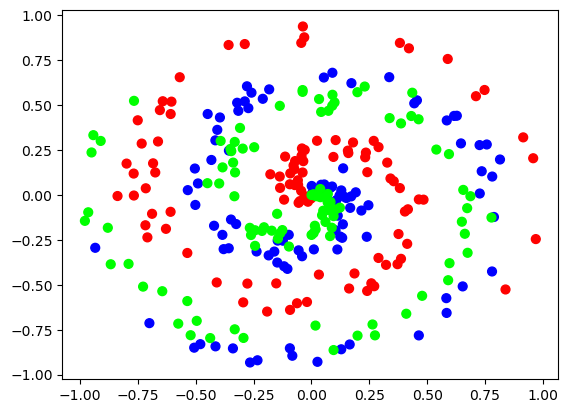

iter  0 : 1.099  acc:0.360 lr: 1.0000
iter  1000 : 0.447  acc:0.837 lr: 0.5003
iter  2000 : 0.282  acc:0.897 lr: 0.3334
iter  3000 : 0.192  acc:0.923 lr: 0.2501
iter  4000 : 0.158  acc:0.940 lr: 0.2000
iter  5000 : 0.145  acc:0.947 lr: 0.1667
iter  6000 : 0.138  acc:0.943 lr: 0.1429
iter  7000 : 0.132  acc:0.947 lr: 0.1250
iter  8000 : 0.128  acc:0.950 lr: 0.1111
iter  9000 : 0.124  acc:0.957 lr: 0.1000
iter  10000 : 0.121  acc:0.957 lr: 0.0909
0.12086431


In [138]:

### Updating the optimizer with the decay rate and momentum
class SGD_optimizer_decay_momentum:
    def __init__(self, learning_rate = 1, decay = 0., momentum = 0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate/ (1 + self.decay*self.iteration)
        
    def update_params(self,layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
                
            weight_updates = self.momentum*layer.weight_momentums - self.current_learning_rate* layer.dweights
            bias_updates = self.momentum*layer.bias_momentums - self.current_learning_rate* layer.dbiases
            layer.weight_momentums = weight_updates
            layer.bias_momentums = bias_updates
            
        else:
            weight_updates = - self.current_learning_rate* layer.dweights
            bias_updates = - self.current_learning_rate* layer.dbiases
        
        
        layer.weights += weight_updates
        layer.biases += bias_updates  

    def post_update_params(self):
        self.iteration += 1
        

# Applying for a Spiral Dataset
### Randomly adjusting weights and biases starting from an initial value
# Create dataset
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()
X,y = spiral_data(samples = 100, classes = 3)
plt.scatter(X[:,0], X[:,1], c = y, s = 40, cmap = 'brg')
plt.show()

# Creating model
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#Declaring optimizer
optimizer = SGD_optimizer_decay_momentum(decay = 0.001, momentum = 0.9)

# Passing the input dataset
dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y)

# Storing variables
min_loss = 99999
best_layer1_weights = dense1.weights.copy()
best_layer1_biases = dense1.biases.copy()
best_layer2_weights = dense2.weights.copy()
best_layer2_biases = dense2.biases.copy()

# Calculating the backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

learning_rate = 1
decay_rate = 0.1
for i in range(10001):
    # Forward pass to update the outputs
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)

    accuracy = np.mean(predictions == y)

    if loss<min_loss:
#         print('The New minimum loss is given in iteration: ', i, ' with a minimum loss:', loss, ' and accuracy:', accuracy)
        best_layer1_weights = dense1.weights.copy()
        best_layer1_biases = dense1.biases.copy()
        best_layer2_weights = dense2.weights.copy()
        best_layer2_biases = dense2.biases.copy()
        min_loss = loss
        
    if not i%1000:
        print('iter ', i, f': {loss:.3f}' , f' acc:{accuracy:.3f}', f'lr: {optimizer.current_learning_rate:.4f}')
    
    # Calculating the backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    
# print(dense1.biases)
# print(dense1.dbiases)
print(min_loss)
    
  

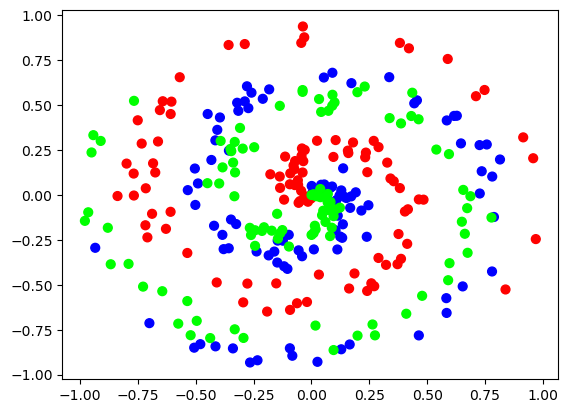

iter  0 : 1.099  acc:0.360 lr: 1.0000
iter  1000 : 0.612  acc:0.720 lr: 0.9092
iter  2000 : 0.520  acc:0.740 lr: 0.8334
iter  3000 : 0.492  acc:0.777 lr: 0.7693
iter  4000 : 0.470  acc:0.777 lr: 0.7143
iter  5000 : 0.456  acc:0.777 lr: 0.6667
iter  6000 : 0.448  acc:0.787 lr: 0.6250
iter  7000 : 0.442  acc:0.800 lr: 0.5883
iter  8000 : 0.436  acc:0.813 lr: 0.5556
iter  9000 : 0.432  acc:0.810 lr: 0.5263
iter  10000 : 0.428  acc:0.817 lr: 0.5000
0.42818177


In [149]:

### Updating the optimizer with the decay rate and using adagrad optimization
class optimizer_Adagrad:
    def __init__(self, learning_rate = 1, decay = 0., epsilon = 1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        self.epsilon = epsilon
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate/ (1 + self.decay*self.iteration)
        
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        
        weight_updates = - self.current_learning_rate* layer.dweights/(np.sqrt(layer.weight_cache + self.epsilon))
        bias_updates = - self.current_learning_rate* layer.dbiases/(np.sqrt(layer.bias_cache + self.epsilon))
        
        layer.weights += weight_updates
        layer.biases += bias_updates  

    def post_update_params(self):
        self.iteration += 1
        

# Applying for a Spiral Dataset
### Randomly adjusting weights and biases starting from an initial value
# Create dataset
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()
X,y = spiral_data(samples = 100, classes = 3)
plt.scatter(X[:,0], X[:,1], c = y, s = 40, cmap = 'brg')
plt.show()

# Creating model
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#Declaring optimizer
optimizer = optimizer_Adagrad(decay = 1e-4)

# Passing the input dataset
dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y)

# Storing variables
min_loss = 99999
best_layer1_weights = dense1.weights.copy()
best_layer1_biases = dense1.biases.copy()
best_layer2_weights = dense2.weights.copy()
best_layer2_biases = dense2.biases.copy()

# Calculating the backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

learning_rate = 1
decay_rate = 0.1
for i in range(10001):
    # Forward pass to update the outputs
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)

    accuracy = np.mean(predictions == y)

    if loss<min_loss:
#         print('The New minimum loss is given in iteration: ', i, ' with a minimum loss:', loss, ' and accuracy:', accuracy)
        best_layer1_weights = dense1.weights.copy()
        best_layer1_biases = dense1.biases.copy()
        best_layer2_weights = dense2.weights.copy()
        best_layer2_biases = dense2.biases.copy()
        min_loss = loss
        
    if not i%1000:
        print('iter ', i, f': {loss:.3f}' , f' acc:{accuracy:.3f}', f'lr: {optimizer.current_learning_rate:.4f}')
    
    # Calculating the backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    
# print(dense1.biases)
# print(dense1.dbiases)
print(min_loss)
    
  

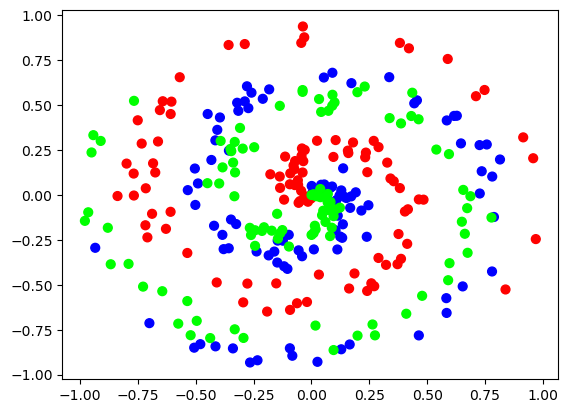

iter  0 : 1.099  acc:0.360 lr: 0.0200
iter  1000 : 0.845  acc:0.573 lr: 0.0198
iter  2000 : 0.817  acc:0.587 lr: 0.0196
iter  3000 : 0.806  acc:0.587 lr: 0.0194
iter  4000 : 0.800  acc:0.590 lr: 0.0192
iter  5000 : 0.797  acc:0.590 lr: 0.0190
iter  6000 : 0.795  acc:0.597 lr: 0.0189
iter  7000 : 0.794  acc:0.587 lr: 0.0187
iter  8000 : 0.789  acc:0.603 lr: 0.0185
iter  9000 : 0.787  acc:0.593 lr: 0.0183
iter  10000 : 0.789  acc:0.593 lr: 0.0182
0.7862689


In [159]:

### Updating the optimizer with the decay rate and using RMSPROP optimization 
# Root Mean square propagation
class optimizer_RMSprop:
    def __init__(self, learning_rate = 1, decay = 0., rho = 0., epsilon = 1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        self.rho = rho
        self.epsilon = epsilon
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate/ (1 + self.decay*self.iteration)
        
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.rho*layer.weight_cache + (1-self.rho)*layer.dweights**2
        layer.bias_cache = self.rho*layer.bias_cache + (1-self.rho)*layer.dbiases**2
        
        weight_updates = - self.current_learning_rate* layer.dweights/(np.sqrt(layer.weight_cache + self.epsilon))
        bias_updates = - self.current_learning_rate* layer.dbiases/(np.sqrt(layer.bias_cache + self.epsilon))
        
        layer.weights += weight_updates
        layer.biases += bias_updates  

    def post_update_params(self):
        self.iteration += 1
        

# Applying for a Spiral Dataset
### Randomly adjusting weights and biases starting from an initial value
# Create dataset
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()
X,y = spiral_data(samples = 100, classes = 3)
plt.scatter(X[:,0], X[:,1], c = y, s = 40, cmap = 'brg')
plt.show()

# Creating model
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#Declaring optimizer
optimizer = optimizer_RMSprop(learning_rate=0.02, decay = 1e-5, rho = 0.999)

# Passing the input dataset
dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y)

# Storing variables
min_loss = 99999
best_layer1_weights = dense1.weights.copy()
best_layer1_biases = dense1.biases.copy()
best_layer2_weights = dense2.weights.copy()
best_layer2_biases = dense2.biases.copy()

# Calculating the backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

learning_rate = 1
decay_rate = 0.1
for i in range(10001):
    # Forward pass to update the outputs
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)

    accuracy = np.mean(predictions == y)

    if loss<min_loss:
#         print('The New minimum loss is given in iteration: ', i, ' with a minimum loss:', loss, ' and accuracy:', accuracy)
        best_layer1_weights = dense1.weights.copy()
        best_layer1_biases = dense1.biases.copy()
        best_layer2_weights = dense2.weights.copy()
        best_layer2_biases = dense2.biases.copy()
        min_loss = loss
        
    if not i%1000:
        print('iter ', i, f': {loss:.3f}' , f' acc:{accuracy:.3f}', f'lr: {optimizer.current_learning_rate:.4f}')
    
    # Calculating the backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    
# print(dense1.biases)
# print(dense1.dbiases)
print(min_loss)
    
  

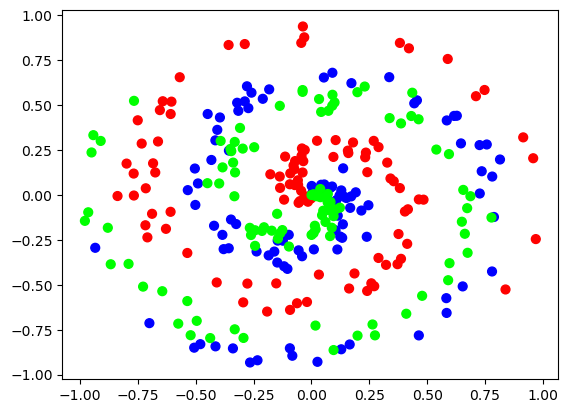

iter  0 : 1.099  acc:0.360 lr: 0.0200
iter  1000 : 0.298  acc:0.890 lr: 0.0198
iter  2000 : 0.225  acc:0.920 lr: 0.0196
iter  3000 : 0.181  acc:0.923 lr: 0.0194
iter  4000 : 0.162  acc:0.927 lr: 0.0192
iter  5000 : 0.148  acc:0.937 lr: 0.0190
iter  6000 : 0.139  acc:0.943 lr: 0.0189
iter  7000 : 0.129  acc:0.947 lr: 0.0187
iter  8000 : 0.128  acc:0.943 lr: 0.0185
iter  9000 : 0.120  acc:0.950 lr: 0.0183
iter  10000 : 0.119  acc:0.950 lr: 0.0182
0.118205614


In [164]:

### Updating the optimizer with the decay rate and using adaptive momentum optimization 
class optimizer_ADAM:
    def __init__(self, learning_rate = 1, decay = 0., epsilon = 1e-7, beta_1 = 0.9, beta_2 = 0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1# momentum factor
        self.beta_2 = beta_2# rho
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate/ (1 + self.decay*self.iteration)
        
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        if not hasattr(layer, 'weight_momentum'):
            layer.weight_momentum = np.zeros_like(layer.weights)
            layer.bias_momentum = np.zeros_like(layer.biases)
            
        layer.weight_cache = self.beta_2*layer.weight_cache + (1-self.beta_2)*layer.dweights**2
        layer.bias_cache = self.beta_2*layer.bias_cache + (1-self.beta_2)*layer.dbiases**2
        
        layer.weight_momentum =  self.beta_1*layer.weight_momentum + (1-self.beta_1)*layer.dweights
        layer.bias_momentum = self.beta_1*layer.bias_momentum + (1-self.beta_1)*layer.dbiases
        
        weight_updates = - self.current_learning_rate* (layer.weight_momentum/(1 - self.beta_1**(self.iteration+1)))/(np.sqrt((layer.weight_cache/(1 - self.beta_2**(self.iteration+1))) + self.epsilon))
        bias_updates = - self.current_learning_rate* (layer.bias_momentum/(1 - self.beta_1**(self.iteration+1)))/(np.sqrt((layer.bias_cache/(1 - self.beta_2**(self.iteration+1))) + self.epsilon))
        
        
        layer.weights += weight_updates
        layer.biases += bias_updates  

    def post_update_params(self):
        self.iteration += 1
        

# Applying for a Spiral Dataset
### Randomly adjusting weights and biases starting from an initial value
# Create dataset
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()
X,y = spiral_data(samples = 100, classes = 3)
plt.scatter(X[:,0], X[:,1], c = y, s = 40, cmap = 'brg')
plt.show()

# Creating model
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#Declaring optimizer
optimizer = optimizer_ADAM(learning_rate=0.02, decay = 1e-5, beta_1 = 0.9, beta_2 = 0.999)

# Passing the input dataset
dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y)

# Storing variables
min_loss = 99999
best_layer1_weights = dense1.weights.copy()
best_layer1_biases = dense1.biases.copy()
best_layer2_weights = dense2.weights.copy()
best_layer2_biases = dense2.biases.copy()

# Calculating the backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

learning_rate = 1
decay_rate = 0.1
for i in range(10001):
    # Forward pass to update the outputs
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)

    accuracy = np.mean(predictions == y)

    if loss<min_loss:
#         print('The New minimum loss is given in iteration: ', i, ' with a minimum loss:', loss, ' and accuracy:', accuracy)
        best_layer1_weights = dense1.weights.copy()
        best_layer1_biases = dense1.biases.copy()
        best_layer2_weights = dense2.weights.copy()
        best_layer2_biases = dense2.biases.copy()
        min_loss = loss
        
    if not i%1000:
        print('iter ', i, f': {loss:.3f}' , f' acc:{accuracy:.3f}', f'lr: {optimizer.current_learning_rate:.4f}')
    
    # Calculating the backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    
# print(dense1.biases)
# print(dense1.dbiases)
print(min_loss)
    
  